# Introduction to Transfer Learning
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Lesson Reference
To supplement the presented material, consult the tutorial here: https://www.tensorflow.org/beta/tutorials/images/transfer_learning
* Freeze most layers, update only certain layer(s), then unfreeze all and update

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_04_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_04_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [2]:
# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import turbo_cmap, reset_keras

# %load_ext tensorboard
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

In [3]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Strategy

The model comprises a block for temporal filters, a block for a spatial filter, a block for further convolutional layers, and a block for the classifier. The spatial filter is going to be unique to each recording, but the other blocks could be shared across recordings.

If we start with a well-performing model for one recording then whenever we switch to a new recording the different sensor locations are going to be a poor fit and create large errors. We don't want those errors to propagate through and update weights in the entire model. For each new recording, we freeze the layers that are shared so they don't update, and we allow only the spatial filter to update. After the spatial filter has updated, we can then unfreeze all layers to perform fine tuning at a lower learning rate.

### Get basic info about each recording

We need to know the data shape for each recording.
We are also goign to take this opportunity to pre-determine the training/validation sets for each recording.

In [40]:
# participant_names = ['ja', 'ca', 'wc', 'de', 'zt', 'fp']
participant_names = ['aa', 'ap', 'ca', 'de', 'fp', 'ha', 'ja',
                     'jm', 'jt', 'rn', 'rr', 'wc', 'zt']
test_participant = 'mv'  # To validate the transfer-learning model vs a naive model.

In [41]:
from data.utils.fileio import load_faces_houses
from collections import OrderedDict
from sklearn.model_selection import StratifiedShuffleSplit

P_TRAIN = 0.8

rec_infos = OrderedDict()
for p_name in participant_names + [test_participant]:
    X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
    n_trials = len(ax_info['instance_data'])
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=0)
    trn, tst = next(sss.split(X, Y))
    rec_infos[p_name] = {
        'n_trials': n_trials,
        'n_timestamps': len(ax_info['timestamps']),
        'fs': ax_info['fs'],
        'n_channels': len(ax_info['channel_names']),
        'trn': trn,
        'tst': tst
    }
    
print([(p_name, info['n_channels']) for p_name, info in rec_infos.items()])

[('aa', 46), ('ap', 41), ('ca', 50), ('de', 31), ('fp', 52), ('ha', 39), ('ja', 60), ('jm', 56), ('jt', 102), ('rn', 42), ('rr', 40), ('wc', 39), ('zt', 58), ('mv', 58)]


### Define the model in parts

In [25]:
# EEGNet-like model with a pair of parallel input layers.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

def make_models(T, aug_offset=100, n_classes=3,
                n_temporal_short=8, len_temporal_short=28,
                n_temporal_long=4, len_temporal_long=220,
                D=2,
                activation='relu',
                downsamp_1=8,
                n_pointwise_filters=25,
                len_kernel_2=47, downsamp_2=5,
                norm_rate=0.45, dropout_rate=0.45, l2_reg=0.0002,
                optimizer_lr=0.0001,
                rec_infos={}):

    # Shared head block:
    # Temporal kernel convolutions.
    _input_head = tf.keras.Input(shape=(T - aug_offset, None, 1))
    
    _y_short = layers.Conv2D(n_temporal_short, (len_temporal_short, 1),
                             padding='same', use_bias=False)(_input_head)
    _y_long = layers.Conv2D(n_temporal_long, (len_temporal_long, 1),
                            padding='same', use_bias=False)(_input_head)
    _y_head = layers.Concatenate(axis=-1)([_y_short, _y_long])
    _y_head = layers.BatchNormalization(axis=1)(_y_head)
    shared_head = tf.keras.Model(inputs=_input_head, outputs=_y_head, name='shared_head')
    shared_head.summary()
    
    # Skip over the spatial filter for now and do
    # Shared tail block: Feature aggregation and classification
    _input_tail = tf.keras.Input(shape=(T - aug_offset, 1,
                                     (n_temporal_short + n_temporal_long) * D ))
    _y_tail = layers.AveragePooling2D((downsamp_1, 1))(_input_tail)
    _y_tail = layers.Dropout(dropout_rate)(_y_tail)
    _y_tail = layers.SeparableConv2D(n_pointwise_filters, (len_kernel_2, 1), padding='valid',
                                use_bias=False)(_y_tail)
    _y_tail = layers.Activation(activation)(_y_tail)
    _y_tail = layers.BatchNormalization(axis=1)(_y_tail)
    _y_tail = layers.AveragePooling2D((downsamp_2, 1))(_y_tail)
    _y_tail = layers.Dropout(dropout_rate)(_y_tail)
    # To class predictions
    _y_tail = layers.Flatten()(_y_tail)
    _y_tail = layers.Dense(n_classes, kernel_constraint=max_norm(norm_rate))(_y_tail)
    _y_tail = layers.Activation('softmax')(_y_tail)
    shared_tail = tf.keras.Model(inputs=_input_tail, outputs=_y_tail, name='shared_tail')
    shared_tail.summary()
    
    optimizer = tf.keras.optimizers.RMSprop(lr=optimizer_lr)
    
    # Create full models for each participant, with each having a unique spatial filter.
    ss_models = OrderedDict()
    for ss_name, ss_info in rec_infos.items():
        _input_full = tf.keras.Input(shape=(T - aug_offset, None, 1))
        
        # Common head
        _y = shared_head(_input_full)
        
        # Spatial Filter
        _y = layers.DepthwiseConv2D((1, ss_info['n_channels']), use_bias=False,
                                    depth_multiplier=D,
                                    kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                    depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                    depthwise_constraint=max_norm(1.))(_y)
        # The order of Activation and BathNormalization is switched here compared to EEGNet.
        # This is because we use relu. relu after normalization discards too much data.
        _y = layers.Activation(activation)(_y)
        _y = layers.BatchNormalization(axis=1)(_y)
        
        # Common tail
        _y = shared_tail(_y)
        
        ss_model = tf.keras.Model(inputs=_input_full, outputs=_y, name=ss_name)
        ss_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizer, metrics=['accuracy'])
        ss_models[ss_name] = ss_model
    
    return shared_head, shared_tail, ss_models

In [42]:
reset_keras(shared_head)
reset_keras(shared_tail)
for _model in ss_models:
    reset_keras(_model)

271062
184
184
184
184
184
184
184
184


In [97]:
MAX_OFFSET = 100
all_ss = participant_names + [test_participant]
T = rec_infos[test_participant]['n_timestamps']  # All recordings should have same timestamps.
shared_head, shared_tail, ss_models = make_models(T,
                                                  n_classes=len(np.unique(Y)),
                                                  aug_offset=MAX_OFFSET,
                                                  rec_infos=rec_infos)
ss_models[test_participant].summary()

# Save the test_participant naive model (random weights even in shared layers) for later.
ss_models[test_participant].save(datadir / 'models' / (test_participant + '_naive.h5'))

Model: "shared_head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 701, None, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 701, None, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 701, None, 4) 880         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 701, None, 12 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]         

#### Prepare Data

In [44]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        # Randomly select an integer between 0 and max_offset
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        # Slice the data to keep samples from t_offset to t_offset + n_subsamps
        # tf.slice syntax arguments are: data, slice starts (per dim), slice length (per dim)
        # Though -1 as a length is special, and means to take all.
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        # Data are by default 64-bit. GPUs work better with 32-bit (or even 16-bit, depending)
        x_dat = tf.cast(x_dat, tf.float32)
        # keras Conv layers expect a 'colour depth' dimension.
        x_dat = tf.expand_dims(x_dat, -1)
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    # Separate input data into training and validation sets.
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    # Prepare (queue?) functions to be run on the data.
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

### Start by training a model normally for one recording

In [45]:
BATCH_SIZE = 10
N_EPOCHS = 100
P_NAME = participant_names[-1]

In [46]:
X, Y, ax_info = load_faces_houses(datadir, P_NAME, feature_set='full')

ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_infos[P_NAME]['trn'],
                                                 rec_infos[P_NAME]['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

reset_keras(ss_models[P_NAME])
reset_keras(ss_models[P_NAME])

history = ss_models[P_NAME].fit(x=ds_train, epochs=N_EPOCHS,
                                validation_data=ds_valid, verbose=1)

589
184
Epoch 1/100
48/48 [==============================] - 2s 45ms/step - loss: 1.1621 - accuracy: 0.3562 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
48/48 [==============================] - 1s 24ms/step - loss: 1.0518 - accuracy: 0.4750 - val_loss: 1.0862 - val_accuracy: 0.4959
Epoch 3/100
48/48 [==============================] - 1s 24ms/step - loss: 0.9750 - accuracy: 0.5604 - val_loss: 1.0686 - val_accuracy: 0.5124
Epoch 4/100
48/48 [==============================] - 1s 24ms/step - loss: 0.8926 - accuracy: 0.6292 - val_loss: 1.0334 - val_accuracy: 0.5372
Epoch 5/100
48/48 [==============================] - 1s 24ms/step - loss: 0.8290 - accuracy: 0.6542 - val_loss: 0.9753 - val_accuracy: 0.6446
Epoch 6/100
48/48 [==============================] - 1s 23ms/step - loss: 0.7435 - accuracy: 0.6792 - val_loss: 0.8970 - val_accuracy: 0.7025
Epoch 7/100
48/48 [==============================] - 1s 24ms/step - loss: 0.6557 - accuracy: 0.7688 - val_loss: 0.8108 - val_accurac

48/48 [==============================] - 1s 24ms/step - loss: 0.0269 - accuracy: 0.9979 - val_loss: 0.1110 - val_accuracy: 0.9835
Epoch 59/100
48/48 [==============================] - 1s 24ms/step - loss: 0.0275 - accuracy: 0.9979 - val_loss: 0.1097 - val_accuracy: 0.9835
Epoch 60/100
48/48 [==============================] - 1s 24ms/step - loss: 0.0331 - accuracy: 0.9937 - val_loss: 0.1121 - val_accuracy: 0.9835
Epoch 61/100
48/48 [==============================] - 1s 24ms/step - loss: 0.0241 - accuracy: 0.9979 - val_loss: 0.1091 - val_accuracy: 0.9835
Epoch 62/100
48/48 [==============================] - 1s 25ms/step - loss: 0.0229 - accuracy: 0.9979 - val_loss: 0.1195 - val_accuracy: 0.9752
Epoch 63/100
48/48 [==============================] - 1s 25ms/step - loss: 0.0277 - accuracy: 0.9958 - val_loss: 0.1081 - val_accuracy: 0.9752
Epoch 64/100
48/48 [==============================] - 1s 25ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.1002 - val_accuracy: 0.9835
Epoch 65/100

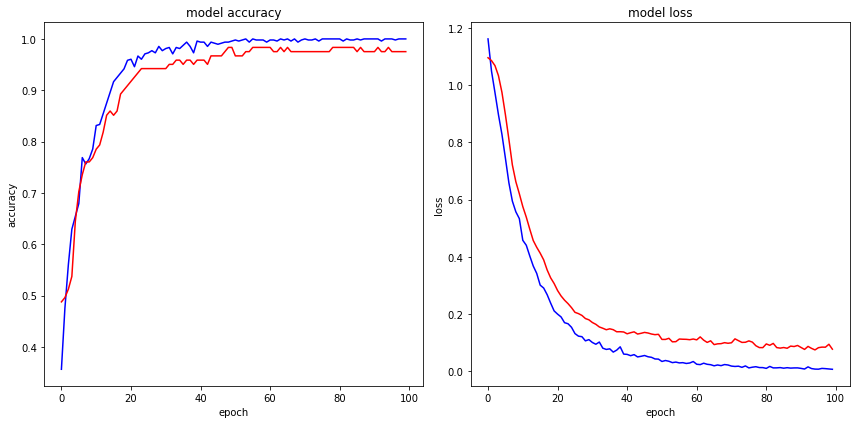

In [47]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

plt.show()

### Train model for each recording with freezing then fine-tuning

In [58]:
BATCH_SIZE = 10
N_EPOCHS_SF = 40
N_EPOCHS_FINETUNE = 60
N_ITERS_ACROSS_SESS = 5
LR_SPAT_FILT = 0.0001
LR_FINE_TUNE = LR_SPAT_FILT / 10

Test freezing the layers. Note you must compile the model after changing 'trainable'.

In [59]:
model = ss_models[participant_names[-1]]
optimizer = tf.keras.optimizers.RMSprop(lr=LR_SPAT_FILT)

shared_head.trainable = True
shared_tail.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
model.summary()

shared_head.trainable = False
shared_tail.trainable = False
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "zt"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 701, None, 1)]    0         
_________________________________________________________________
shared_head (Model)          (None, 701, None, 12)     3908      
_________________________________________________________________
depthwise_conv2d_12 (Depthwi (None, 701, None, 24)     1392      
_________________________________________________________________
activation_14 (Activation)   (None, 701, None, 24)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 701, None, 24)     2804      
_________________________________________________________________
shared_tail (Model)          (None, 3)                 2495      
Total params: 10,599
Trainable params: 7,713
Non-trainable params: 2,886
_________________________________________________________

In [65]:
hists = {}
for ep_ix in range(N_ITERS_ACROSS_SESS):
    for idx in np.random.permutation(len(participant_names)):
        
        p_name = participant_names[idx]
        rec_info = rec_infos[p_name]
        
        # Load data for this session
        X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
        
        # Prepare the data for DL
        ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                         rec_info['trn'],
                                                         rec_info['tst'],
                                                         batch_size=BATCH_SIZE,
                                                         max_offset=MAX_OFFSET)
        
        # Get the model for this session.
        # The weights should carry over from previous learning.
        # But we still have to freeze layers and compile with correct optimizer lr.
        model = ss_models[p_name]
        shared_head.trainable = False
        shared_tail.trainable = False
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_SPAT_FILT)
        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer, metrics=['accuracy'])
        
        # Train model
        print("Training model {} ({} of {})".format(model.name, ep_ix + 1,
                                                    N_ITERS_ACROSS_SESS))
        hist_1 = model.fit(x=ds_train,
                           epochs=N_EPOCHS_SF,
                           validation_data=ds_valid,
                           verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_1.history['accuracy'][-1], hist_1.history['val_accuracy'][-1]))
        
        # Fine-tune model
        shared_head.trainable = True
        shared_tail.trainable = True
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_FINE_TUNE)
        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer, metrics=['accuracy'])
        
        print("Fine-tuning model {} ({} of {})".format(model.name, ep_ix + 1,
                                                       N_ITERS_ACROSS_SESS))
        hist_2 = model.fit(x=ds_train,
                           epochs=N_EPOCHS_FINETUNE,
                           validation_data=ds_valid,
                           verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_2.history['accuracy'][-1], hist_2.history['val_accuracy'][-1]))
        
        if p_name not in hists:
            hists[p_name] = []
        hists[p_name].append(hist_1.history)
        hists[p_name].append(hist_2.history)

Training model wc (1 of 5)
Ending acc and val acc: 0.891, 0.882
Fine-tuning model wc (1 of 5)
Ending acc and val acc: 0.955, 0.882
Training model fp (1 of 5)
Ending acc and val acc: 0.925, 0.884
Fine-tuning model fp (1 of 5)
Ending acc and val acc: 0.958, 0.901
Training model ca (1 of 5)
Ending acc and val acc: 0.924, 0.814
Fine-tuning model ca (1 of 5)
Ending acc and val acc: 0.936, 0.832
Training model de (1 of 5)
Ending acc and val acc: 0.904, 0.868
Fine-tuning model de (1 of 5)
Ending acc and val acc: 0.935, 0.917
Training model zt (1 of 5)
Ending acc and val acc: 0.998, 0.983
Fine-tuning model zt (1 of 5)
Ending acc and val acc: 1.000, 0.983
Training model jm (1 of 5)
Ending acc and val acc: 0.830, 0.786
Fine-tuning model jm (1 of 5)
Ending acc and val acc: 0.878, 0.812
Training model aa (1 of 5)
Ending acc and val acc: 0.837, 0.764
Fine-tuning model aa (1 of 5)
Ending acc and val acc: 0.872, 0.773
Training model jt (1 of 5)
Ending acc and val acc: 0.900, 0.774
Fine-tuning model j

Ending acc and val acc: 1.000, 0.992
Training model ja (5 of 5)
Ending acc and val acc: 1.000, 0.924
Fine-tuning model ja (5 of 5)
Ending acc and val acc: 0.998, 0.941
Training model fp (5 of 5)
Ending acc and val acc: 0.994, 0.934
Fine-tuning model fp (5 of 5)
Ending acc and val acc: 1.000, 0.942


In [88]:
shared_head.save(datadir / 'models' / 'shared_head.h5')
shared_tail.save(datadir / 'models' / 'shared_tail.h5')
for _name, _model in ss_models.items():
    _model.save(datadir / 'models' / (_name + '_xfer.h5'))

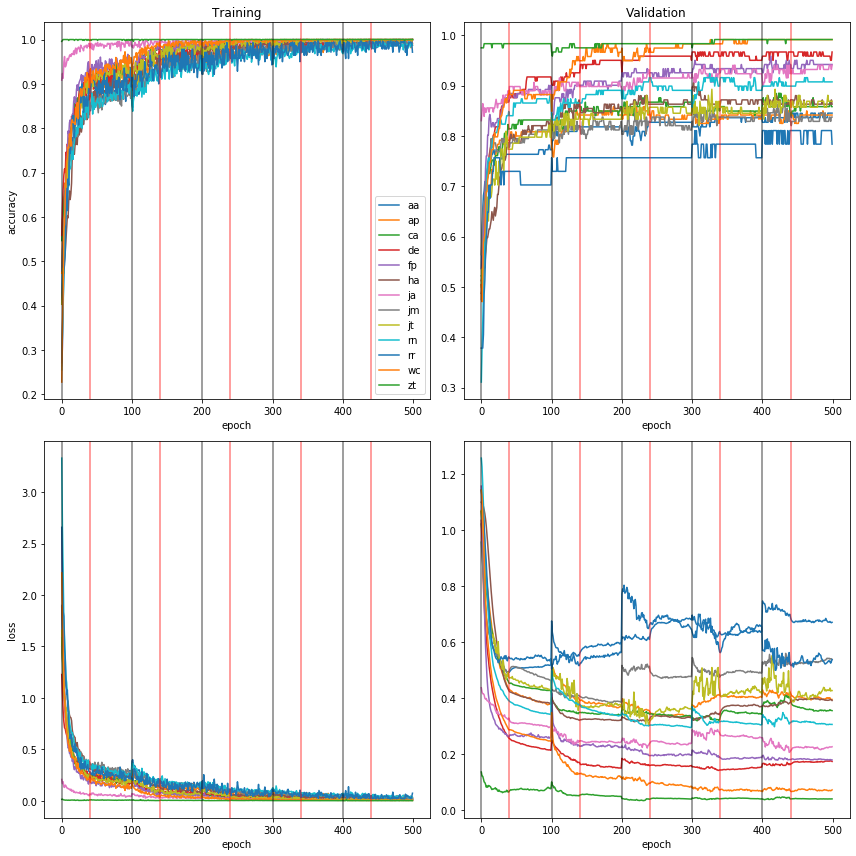

In [84]:
agg_hists = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
for p_name in participant_names:
    for k in agg_hists.keys():
        agg_hists[k].append(np.hstack([_[k] for _ in hists[p_name]]))
for k in agg_hists.keys():
    agg_hists[k] = np.vstack(agg_hists[k])

sess_breaks = np.arange(N_ITERS_ACROSS_SESS) * (N_EPOCHS_SF + N_EPOCHS_FINETUNE)
finetune_breaks = sess_breaks + N_EPOCHS_SF

fig = plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 2, 1)
for p_ix, p_name in enumerate(participant_names):
    plt.plot(agg_hists['accuracy'][p_ix], label=p_name)
for xx in sess_breaks:
    plt.axvline(xx, color='k', alpha=0.5)
for xx in finetune_breaks:
    plt.axvline(xx, color='r', alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training')
plt.legend(loc='lower right')
plt.subplot(2, 2, 2)
plt.plot(agg_hists['val_accuracy'].T)
for xx in sess_breaks:
    plt.axvline(xx, color='k', alpha=0.5)
for xx in finetune_breaks:
    plt.axvline(xx, color='r', alpha=0.5)
plt.xlabel('epoch')
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(agg_hists['loss'].T)
for xx in sess_breaks:
    plt.axvline(xx, color='k', alpha=0.5)
for xx in finetune_breaks:
    plt.axvline(xx, color='r', alpha=0.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(2, 2, 4)
plt.plot(agg_hists['val_loss'].T)
for xx in sess_breaks:
    plt.axvline(xx, color='k', alpha=0.5)
for xx in finetune_breaks:
    plt.axvline(xx, color='r', alpha=0.5)
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

Classification accuracy on the validation set seems to improve as the shared models are updated with each recording.

Validation loss improves for many but not all data sets.

## Transfer the model to unseen data

A single 'test participant' was not included in the above training. Let's see how well we can classify data from this participant using a model that is pre-initialized with weights learned from other subjects and a naive model with random initial weights.

In [112]:
# First clear all models from memory.
reset_keras(shared_head)
reset_keras(shared_tail)
for _model in ss_models:
    reset_keras(_model)
    
# Then load the saved models from disk.
# shared_head = tf.keras.models.load_model(datadir / 'models' / 'shared_head.h5')
# shared_tail = tf.keras.models.load_model(datadir / 'models' / 'shared_tail.h5')
xfer_model =  tf.keras.models.load_model(datadir / 'models' / (test_participant + '_xfer.h5'))
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
shared_layers = [0, 1, 5]

naive_model = tf.keras.models.load_model(datadir / 'models' / (test_participant + '_naive.h5'))
naive_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])

474630
184
184
184
184
184
184
184
184
184
184
184
184
184
184
184


In [113]:
N_EPOCHS = 150
N_EPOCHS_SF = 20

rec_info = rec_infos[test_participant]

# Load data for this session
X, Y, ax_info = load_faces_houses(datadir, test_participant, feature_set='full')

# Prepare the data for DL
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_info['trn'],
                                                 rec_info['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

# Train model
print("Training xfer model {} spatial filter".format(xfer_model.name))
for layer_ix in shared_layers:
    xfer_model.layers[layer_ix].trainable = False
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_sf = xfer_model.fit(x=ds_train,
                              epochs=N_EPOCHS_SF,
                              validation_data=ds_valid,
                              verbose=1)
print("Training xfer model {} entirity".format(xfer_model.name))
for layer_ix in shared_layers:
    xfer_model.layers[layer_ix].trainable = True
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_all = xfer_model.fit(x=ds_train,
                               epochs=N_EPOCHS - N_EPOCHS_SF,
                               validation_data=ds_valid,
                               verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_xfer_all.history['accuracy'][-1], hist_xfer_all.history['val_accuracy'][-1]))

# Train naive model
print("Training naive model {}".format(naive_model.name))
hist_naive = naive_model.fit(x=ds_train,
                             epochs=N_EPOCHS,
                             validation_data=ds_valid,
                             verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_naive.history['accuracy'][-1], hist_naive.history['val_accuracy'][-1]))

Training xfer model mv spatial filter
Epoch 1/20
48/48 [==============================] - 2s 34ms/step - loss: 1.8356 - accuracy: 0.5875 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
48/48 [==============================] - 1s 18ms/step - loss: 0.9819 - accuracy: 0.7292 - val_loss: 1.1954 - val_accuracy: 0.5289
Epoch 3/20
48/48 [==============================] - 1s 18ms/step - loss: 0.6058 - accuracy: 0.7937 - val_loss: 1.0144 - val_accuracy: 0.5785
Epoch 4/20
48/48 [==============================] - 1s 18ms/step - loss: 0.4846 - accuracy: 0.8396 - val_loss: 0.8619 - val_accuracy: 0.6198
Epoch 5/20
48/48 [==============================] - 1s 18ms/step - loss: 0.4038 - accuracy: 0.8625 - val_loss: 0.7597 - val_accuracy: 0.6942
Epoch 6/20
48/48 [==============================] - 1s 18ms/step - loss: 0.3769 - accuracy: 0.8438 - val_loss: 0.7414 - val_accuracy: 0.7025
Epoch 7/20
48/48 [==============================] - 1s 18ms/step - loss: 0.2882 - accuracy: 0.8771 - val_los

Epoch 38/130
48/48 [==============================] - 1s 25ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 0.4014 - val_accuracy: 0.8760
Epoch 39/130
48/48 [==============================] - 1s 25ms/step - loss: 0.0299 - accuracy: 0.9937 - val_loss: 0.4138 - val_accuracy: 0.9008
Epoch 40/130
48/48 [==============================] - 1s 25ms/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.4032 - val_accuracy: 0.8760
Epoch 41/130
48/48 [==============================] - 1s 25ms/step - loss: 0.0455 - accuracy: 0.9896 - val_loss: 0.4758 - val_accuracy: 0.8843
Epoch 42/130
48/48 [==============================] - 1s 24ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.5341 - val_accuracy: 0.8760
Epoch 43/130
48/48 [==============================] - 1s 25ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.3361 - val_accuracy: 0.9091
Epoch 44/130
48/48 [==============================] - 1s 24ms/step - loss: 0.0102 - accuracy: 0.9958 - val_loss: 0.2615 - val_accuracy: 0.9091

48/48 [==============================] - 1s 24ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2308 - val_accuracy: 0.9091
Epoch 96/130
48/48 [==============================] - 1s 24ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1827 - val_accuracy: 0.9174
Epoch 97/130
48/48 [==============================] - 1s 24ms/step - loss: 0.0091 - accuracy: 0.9979 - val_loss: 0.2519 - val_accuracy: 0.9091
Epoch 98/130
48/48 [==============================] - 1s 24ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2193 - val_accuracy: 0.9256
Epoch 99/130
48/48 [==============================] - 1s 24ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2609 - val_accuracy: 0.9008
Epoch 100/130
48/48 [==============================] - 1s 24ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.2904 - val_accuracy: 0.9008
Epoch 101/130
48/48 [==============================] - 1s 25ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2065 - val_accuracy: 0.9174
Epoch 102/

Epoch 22/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0594 - accuracy: 0.9875 - val_loss: 0.1734 - val_accuracy: 0.9421
Epoch 23/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0504 - accuracy: 0.9917 - val_loss: 0.2248 - val_accuracy: 0.9091
Epoch 24/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0527 - accuracy: 0.9854 - val_loss: 0.1899 - val_accuracy: 0.9091
Epoch 25/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0418 - accuracy: 0.9854 - val_loss: 0.2077 - val_accuracy: 0.9174
Epoch 26/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0473 - accuracy: 0.9875 - val_loss: 0.1575 - val_accuracy: 0.9256
Epoch 27/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0321 - accuracy: 0.9937 - val_loss: 0.1493 - val_accuracy: 0.9339
Epoch 28/150
48/48 [==============================] - 1s 23ms/step - loss: 0.0379 - accuracy: 0.9896 - val_loss: 0.1967 - val_accuracy: 0.9174

48/48 [==============================] - 1s 24ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.1773 - val_accuracy: 0.9256
Epoch 80/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1791 - val_accuracy: 0.9421
Epoch 81/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0251 - accuracy: 0.9937 - val_loss: 0.2238 - val_accuracy: 0.9339
Epoch 82/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1991 - val_accuracy: 0.9256
Epoch 83/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0121 - accuracy: 0.9979 - val_loss: 0.2334 - val_accuracy: 0.9256
Epoch 84/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.2457 - val_accuracy: 0.9091
Epoch 85/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0088 - accuracy: 0.9979 - val_loss: 0.1771 - val_accuracy: 0.9256
Epoch 86/150

48/48 [==============================] - 1s 25ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1958 - val_accuracy: 0.9339
Epoch 137/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.1214 - val_accuracy: 0.9587
Epoch 138/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0046 - accuracy: 0.9979 - val_loss: 0.1225 - val_accuracy: 0.9752
Epoch 139/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1318 - val_accuracy: 0.9587
Epoch 140/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1355 - val_accuracy: 0.9587
Epoch 141/150
48/48 [==============================] - 1s 24ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1326 - val_accuracy: 0.9587
Epoch 142/150
48/48 [==============================] - 1s 25ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1362 - val_accuracy: 0.9587
Epoch 

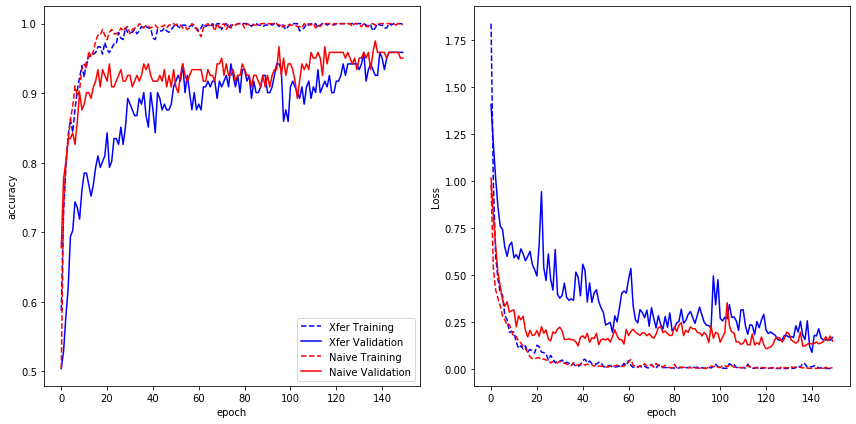

In [114]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
hist_xfer = {}
for k in hist_xfer_sf.history.keys():
    hist_xfer[k] = hist_xfer_sf.history[k] + hist_xfer_all.history[k]
plt.subplot(1, 2, 1)
plt.plot(hist_xfer['accuracy'], 'b--', label='Xfer Training')
plt.plot(hist_xfer['val_accuracy'], 'b', label='Xfer Validation')
plt.plot(hist_naive.history['accuracy'], 'r--', label='Naive Training')
plt.plot(hist_naive.history['val_accuracy'], 'r', label='Naive Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(hist_xfer['loss'], 'b--', label='Xfer Training')
plt.plot(hist_xfer['val_loss'], 'b', label='Xfer Validation')
plt.plot(hist_naive.history['loss'], 'r--', label='Naive Training')
plt.plot(hist_naive.history['val_loss'], 'r', label='Naive Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

oof. Not what we were hoping for. The model with randomly-initialized weights (naive) trained faster and had higher peak accuracy than the model with weights trained on data from other sessions (Xfer).

There are a couple things we could do differently:

1. For each of the training sessions, calculate the covariance matrix for the output of the spatial filter. Then, for the test session, find a mapping from sensor space to a space that has similar covariance. Use this mapping to initialize the spatial filter in the test transfer model.
2. The intended use case of the transfer model on a new dataset is to given decent performance when there is a paucity of training data. We can simulate that by running the above analysis for different levels of training data.